# Figure 3: Secondary structural elements mediate differential tolerance to deletions versus substitutions

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
from sklearn.mixture import GaussianMixture
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
import os
import paths
import numpy as np
import random
from zipfile import ZipFile

### Extract secondary structural elements 

### AlphaFold PDB files can be downloaded from https://alphafold.ebi.ac.uk/download

In [2]:
def get_dssp(pdb_path: str, prot_id: str) -> pd.DataFrame:

    # Create a PDB parser object
    parser = PDBParser()
    pdb_file = pdb_path
    structure = parser.get_structure("my_structure", pdb_file)

    # Create a DSSP object to calculate secondary structure
    model = structure[0]  # Assuming there's only one model in the structure
    dssp = DSSP(model, pdb_file)

    # Extract DSSP predictions
    res = []
    for residue in dssp.keys():
        
        res.append([prot_id, dssp[residue][0], dssp[residue][2]])
        
    return pd.DataFrame(res, columns=["prot", "pos", "ss"])

In [3]:
secondary_structs = []
for file in tqdm.tqdm(filter(lambda x: ".pdb" in x, os.listdir(paths.AF_PDB))):
    secondary_structs.append(get_dssp(paths.AF_PDB + "/" + file, file.split("-")[1]))
secondary_structs = pd.concat(secondary_structs)

20150it [19:17, 17.41it/s]


In [4]:
# via https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/protein-secondary-structure
dssp_code_mapping = {"H": "HELIX", "B": "STRAND", "E": "STRAND", "G": "HELIX", "I": "HELIX", "T": "TURN", "S": "TURN", "-": "-"}
secondary_structs["group_struct"] = secondary_structs.ss.map(dssp_code_mapping)

## Figure A

### Load in genome-wide and differentially tolerant data

In [5]:
del_sub = pd.read_csv(paths.DEL_SUB).assign(aPLLR=lambda x: np.abs(x.PLLR))[["site", "prot", "aPLLR", "avg_LLR"]].assign(pos=lambda x: x.site.str[1:].astype(int))
del_sub["log_aPLLR"] = -np.log10(del_sub.aPLLR)
# restrict to canonical transcripts
del_sub = del_sub[~del_sub.prot.str.contains("-")]

cutoff=25
del_tol, del_intol = np.percentile(del_sub.aPLLR, cutoff), np.percentile(del_sub.aPLLR, 100-cutoff)
sub_intol, sub_tol = np.percentile(del_sub.avg_LLR, cutoff), np.percentile(del_sub.avg_LLR, 100-cutoff)

del_intol_sub_tol = del_sub[(del_sub.aPLLR > del_intol) & (del_sub.avg_LLR > sub_tol)]
del_tol_sub_intol = del_sub[(del_sub.aPLLR < del_tol) & (del_sub.avg_LLR < sub_intol)]

### Distribution of elements in each condition

In [6]:
del_sub_merge_structs = del_sub.merge(secondary_structs, on=["prot", "pos"]) # merge in the secondary structural information
del_intol_sub_tol_structs = del_intol_sub_tol.merge(secondary_structs, on=["prot", "pos"])
del_tol_sub_intol_structs = del_tol_sub_intol.merge(secondary_structs, on=["prot", "pos"])

In [7]:
bg_freq = dict(sorted(dict(del_sub_merge_structs.group_struct.value_counts(normalize=True)).items(), key=lambda x: x[0]))
del_intol_sub_tol_structs_freq =  dict(sorted(dict(del_intol_sub_tol_structs.group_struct.value_counts(normalize=True)).items(), key=lambda x: x[0]))
del_tol_sub_intol_structs_freq =  dict(sorted(dict(del_tol_sub_intol_structs.group_struct.value_counts(normalize=True)).items(), key=lambda x: x[0]))

### Plot data

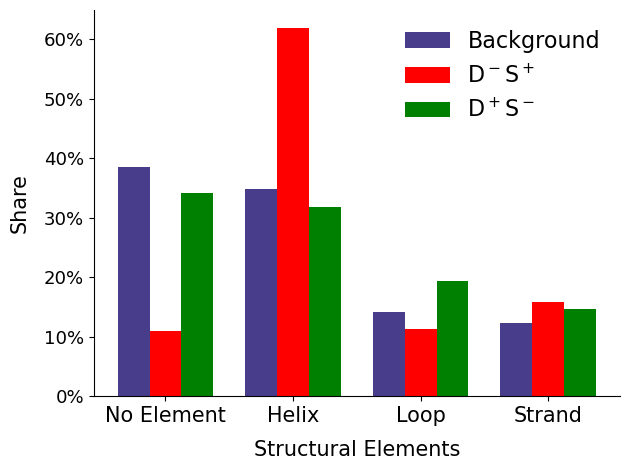

In [8]:
categories = ["-", "HELIX", "TURN", "STRAND"]
frequencies1 = [bg_freq[x] for x in categories]
frequencies2 = [del_intol_sub_tol_structs_freq[x] for x in categories]
frequencies3 = [del_tol_sub_intol_structs_freq[x] for x in categories]

# Set the bar width
bar_width = 0.25

# Set the positions of bars on X-axis
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar plot
plt.bar(r1, frequencies1, color='darkslateblue', width=bar_width, label='Background')
plt.bar(r2, frequencies2, color='red', width=bar_width, label=r'D$^-$S$^+$')
plt.bar(r3, frequencies3, color='green', width=bar_width, label=r'D$^+$S$^-$')

plt.ylabel('Share', fontsize=15, labelpad=10)
plt.yticks([x/10 for x in range(7)], [f"{x*10}%" for x in range(7)], fontsize=13)
plt.xticks([r + bar_width for r in range(len(categories))], ["No Element", "Helix",  "Loop", "Strand"], fontsize=15)
plt.xlabel("Structural Elements", fontsize=15, labelpad=10)

plt.legend(frameon=False, fontsize=16)
plt.tight_layout()

plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()

## Figure B

### Load in a sample of LLR (substitution) data

In [9]:
def meltLLR(LLR,gene_prefix=None,ignore_pos=False):
    vars = LLR.melt(ignore_index=False)
    vars['variant'] = [''.join(i.split(' '))+j for i,j in zip(vars['variable'],vars.index)]
    vars['score'] = vars['value']
    vars = vars.set_index('variant')
    if not ignore_pos:
        vars['pos'] = [int(i[1:-1]) for i in vars.index]
    del vars['variable'],vars['value']
    if gene_prefix is not None:
        vars.index=gene_prefix+'_'+vars.index
    return vars

### Read in LLR data, can be downloaded from https://huggingface.co/spaces/ntranoslab/esm_variants/blob/main/ALL_hum_isoforms_ESM1b_LLR.zip

In [10]:
zf = ZipFile(paths.LLRS)

In [11]:
all_llrs = []
selected_prots = del_sub.drop_duplicates(subset="prot").sample(frac=0.01, random_state=10).prot
have_llrs = set(y.split("/")[1].split("_")[0]
                for y in (filter(lambda x: "MACOSX" not in x and ".csv" in x,
                                 zf.namelist())))
for p in tqdm.tqdm(set(selected_prots) & have_llrs):
    df = meltLLR(pd.read_csv(zf.open(f'ALL_hum_isoforms_ESM1b_LLR/{p}_LLR.csv'), index_col=0)).reset_index()
    df = df[df.variant.str[0] != df.variant.str[-1]]
    df["prot"] = p
    all_llrs.append(df)
all_llrs = pd.concat(all_llrs)

100%|██████████| 203/203 [00:06<00:00, 32.86it/s]


### Extract data in each condition:
    - Within helix, W>G
    - All W>G
    - All helix
    - All variants

In [12]:
all_w2g_llr = pd.read_csv("../data/all_w2g_llr.csv.gz")
all_helix_llr = pd.read_csv("../data/all_helix_llr.csv.gz")

In [13]:
w2g_helix = all_w2g_llr.merge(all_helix_llr[["variant", "prot"]], on=["variant", "prot"])

### Apply Gaussian mixture

In [14]:
share_pathogenic = []
for data in [w2g_helix[["score"]], all_w2g_llr[["score"]], all_helix_llr.sample(frac=0.1)[["score"]], all_llrs[["score"]]]:
    gmm = GaussianMixture(n_components=2).fit(data)
    
    means = gmm.means_.flatten()
    covariances = gmm.covariances_.flatten()
    weights = gmm.weights_
        
    pathogenic_cluster = 0 if means[0] < means[1] else 1
    # Share of data in pathogenic cluster
    sp = 1-gmm.predict(data).mean() if pathogenic_cluster == 0 else gmm.predict(data).mean()
    share_pathogenic.append(sp)

### Plot data

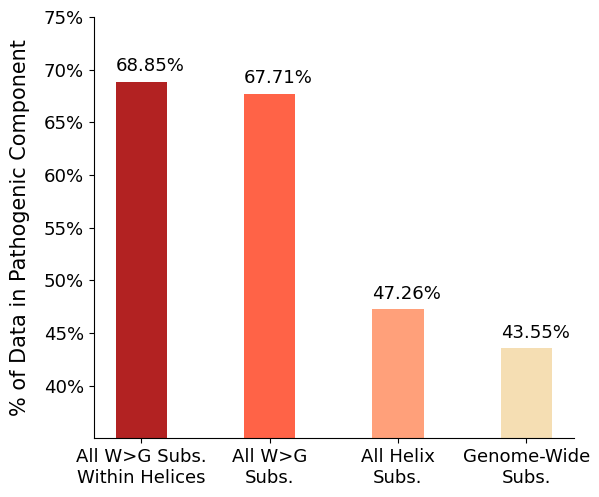

In [15]:
plt.figure(figsize=(6, 5))
plt.bar([0, 1, 2, 3], share_pathogenic, width=0.4, color=["firebrick", "tomato", "lightsalmon", "wheat"])
plt.xticks([0, 1, 2, 3], ["All W>G Subs.\nWithin Helices", "All W>G\nSubs.", "All Helix\nSubs.", "Genome-Wide\nSubs."], fontsize=13)
plt.gca().spines[["top", "right"]].set_visible(False)
plt.ylabel("% of Data in Pathogenic Component", fontsize=15, labelpad=10)
plt.yticks(size=13)
plt.tight_layout()
plt.ylim(0.35, 0.75)
plt.yticks(np.arange(0.4, 0.80, 0.05), [f"{round(x*100)}%" for x in np.arange(0.4, 0.8, 0.05)])
for i in range(4):
    plt.text(i-0.2, share_pathogenic[i]+0.01, f"{np.round(share_pathogenic[i]*100, 2)}%", size=13)

## Figure C

In [16]:
ins_sub_scan = pd.read_csv("../data/esm_ins_sub_pllr.csv.gz")

### Determine if position is inside a helix

In [17]:
helices = secondary_structs[secondary_structs.group_struct == "HELIX"]
prot_helices_pos = {x: list(helices[helices.prot == x].pos) for x in ins_sub_scan.prot.unique()}

In [18]:
def within_helix(target_pos: int, target_prot: str) -> bool:
    """
    Check if the position and the position+1 are helix,
    because I insert to the right of the position.
    """
    return target_pos in prot_helices_pos[target_prot] and target_pos+1 in prot_helices_pos[target_prot]

In [19]:
ins_sub_scan["within_helix"] = ins_sub_scan.apply(lambda x: within_helix(int(x.substitution[1:-1]), x.prot), axis=1)

### Plot data

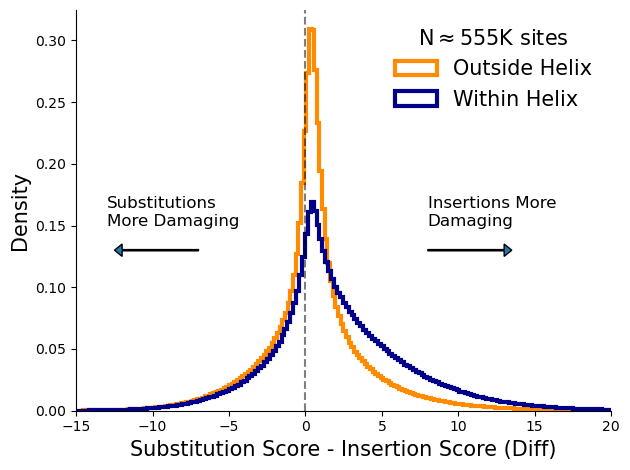

In [20]:
num_sites = round(ins_sub_scan[["substitution", "prot"]].assign(pos = lambda x: x.substitution.str[:-1])[["pos", "prot"]].drop_duplicates().shape[0] / 1000)

# insertion versus substitution effect within helix 
_=plt.hist(ins_sub_scan[~ins_sub_scan.within_helix].query('wt==False').ins_sub_diff, density=True, bins=500, histtype="step", label="Outside Helix", lw=3, color="darkorange")
# insertion versus substitution effect outside helix 
_=plt.hist(ins_sub_scan[ins_sub_scan.within_helix].query('wt==False').ins_sub_diff, density=True, bins=500, histtype="step", label="Within Helix", lw=3, color="darkblue")
_=plt.axvline(0, color="black", ls="--", alpha=0.5)
# formatting
plt.xlim(-15, 20)
plt.text(8, 0.15, "Insertions More\nDamaging", fontsize=12)
plt.arrow(8, 0.13, 5, 0, head_length=0.5, head_width=0.01)
plt.text(-13, 0.15, "Substitutions\nMore Damaging", fontsize=12)
plt.arrow(-7, 0.13, -5, 0, head_length=0.5, head_width=0.01)
# labels, titles, etc
plt.xlabel("Substitution Score - Insertion Score (Diff)", fontsize=15)
plt.ylabel("Density", fontsize=15)
legend = plt.legend(frameon=False, fontsize=15, title="N" + r'$\approx$' + f"{num_sites}K sites")
legend.get_title().set_fontsize('15')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## Figure D

### Load in data

In [21]:
tsuboyama = pd.read_csv("../data/tsuboyama_ddg.csv")

In [22]:
struct_ddg = {}
dssp_struct = {"H": "Helix", "L": "Loop", "E": "Strand"}
for struct in dssp_struct.keys():
    struct_ddg[struct] = (tsuboyama.query(f'dssp == "{struct}"')[["ddG_ML_ins_ala", "ddG_ML_ins_gly", "ddG_ML_dels"]].mean() / tsuboyama.query(f'dssp == "{struct}"')[["ddG_ML_avg_subs"]].mean().iloc[0]).iloc[0:3].to_list()

In [23]:
def grouped_bar_plot(categories: list, values_list:list, group_labels: list=None, colors: list=None,
                    xlab: str=None, ylab: str=None, title: str=None, lfs: int=None) -> None:
    
    num_categories = len(categories)
    num_groups = len(values_list)

    # Setting the positions for the bars
    x = np.arange(num_categories)
    width = 0.2# Width of the bars
        
    # Plotting the grouped bar plot
    fig, ax = plt.subplots()
    for i, values in enumerate(values_list):
        if group_labels:
            label = group_labels[i]
        else:
            label = f'Group {i+1}'
        ax.bar(x + width*(i - num_groups/num_categories), values, width, label=label, color=colors[i])

    # Adding labels, title, and legend
    ax.set_xlabel(xlab, size=15)
    ax.set_ylabel(ylab, size=15)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=15)
    ax.legend(frameon=False, prop={"size": lfs})
    plt.tight_layout()

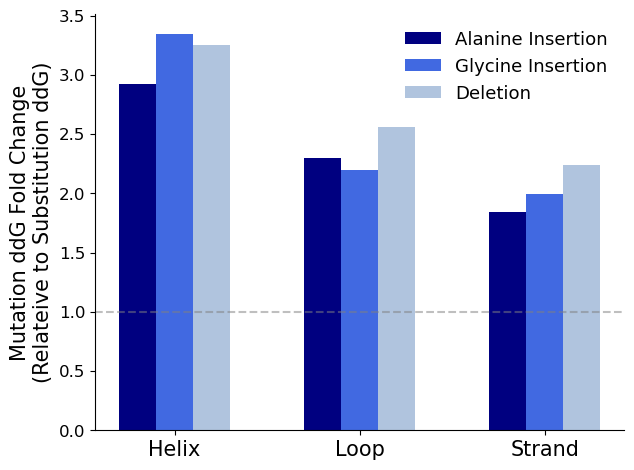

In [24]:
grouped_bar_plot([dssp_struct[x] for x in list(struct_ddg.keys())], list(np.array(list(struct_ddg.values())).T),
                ["Alanine Insertion", "Glycine Insertion", "Deletion"], ylab="Mutation ddG Fold Change\n(Relateive to Substitution ddG)",
                colors=["navy", "royalblue", "lightsteelblue"], lfs=13)
plt.axhline(1, color="grey", ls="--", alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(size=12)
plt.show()